In [35]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import caffe

# matplotlib config
plt.rcParams['figure.figsize'] = (10, 10)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

In [12]:
caffe.set_device(0)
caffe.set_mode_gpu()

from train_places_net import get_split, miniplaces_net, MEAN
net_path = miniplaces_net(
    get_split('val'), crop=96, batch=256, image_root="./images/",
    train=False, cudnn=False, with_labels=False)

Set Caffe to CPU mode, load the net in the test phase for inference, and configure input preprocessing.

In [13]:
net = caffe.Net(net_path, 'snapshot/place_net_iter_1.caffemodel', caffe.TEST)

# input preprocessing: 'data' is the name of the input blob == net.inputs[0]
transformer = caffe.io.Transformer({'data': net.blobs['data'].data.shape})
transformer.set_transpose('data', (2,0,1))
transformer.set_mean('data', np.array(MEAN)) # mean pixel
transformer.set_raw_scale('data', 255)  # the reference model operates on images in [0,255] range instead of [0,1]
transformer.set_channel_swap('data', (2,1,0))  # the reference model has channels in BGR order instead of RGB

Let's start with a simple classification. We'll set a batch of 50 to demonstrate batch processing, even though we'll only be classifying one image. (Note that the batch size can also be changed on-the-fly.)

In [14]:
# set net to batch size of 50
net.blobs['data'].reshape(50,3,96,96)

Feed in the image (with some preprocessing) and classify with a forward pass.

In [20]:
net.blobs['data'].data[...] = transformer.preprocess('data', caffe.io.load_image('images/test/00010000.jpg'))
out = net.forward()
print("Predicted class is #{}.".format(out['probs'][0].argmax()))

Predicted class is #11.


What did the input look like?

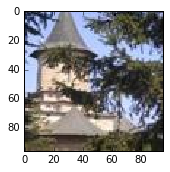

In [25]:
plt.imshow(transformer.deprocess('data', net.blobs['data'].data[0]))

Adorable, but was our classification correct?

In [28]:
# load labels
labels_filename = 'development_kit/data/categories.txt'
labels = np.loadtxt(labels_filename, str, delimiter=' ')

# sort top k predictions from softmax output
top_k = net.blobs['probs'].data[0].flatten().argsort()[-1:-6:-1]
print labels[top_k]

[['/b/ballroom' '11']
 ['/c/church/outdoor' '32']
 ['/f/fountain' '49']
 ['/m/monastery/outdoor' '67']
 ['/b/bakery/shop' '10']]


First, the layer features and their shapes (1 is the batch size, corresponding to the single input image in this example).

In [31]:
[(k, v.data.shape) for k, v in net.blobs.items()]

[('data', (100, 3, 96, 96)),
 ('ignored_label', (100,)),
 ('conv1', (100, 96, 45, 45)),
 ('norm1', (100, 96, 45, 45)),
 ('pool1', (100, 96, 15, 15)),
 ('conv2', (100, 256, 11, 11)),
 ('pool2', (100, 256, 6, 6)),
 ('conv3', (100, 512, 6, 6)),
 ('conv4', (100, 512, 6, 6)),
 ('conv5', (100, 512, 5, 5)),
 ('pool5', (100, 512, 2, 2)),
 ('conv6', (100, 384, 2, 2)),
 ('conv7', (100, 384, 2, 2)),
 ('conv8', (100, 256, 2, 2)),
 ('pool8', (100, 256, 1, 1)),
 ('fc9', (100, 2048)),
 ('fc10', (100, 1024)),
 ('fc11', (100, 100)),
 ('probs', (100, 100))]

The parameters and their shapes. The parameters are `net.params['name'][0]` while biases are `net.params['name'][1]`.

In [32]:
[(k, v[0].data.shape) for k, v in net.params.items()]

[('conv1', (96, 3, 7, 7)),
 ('conv2', (256, 48, 5, 5)),
 ('conv3', (512, 256, 3, 3)),
 ('conv4', (512, 256, 3, 3)),
 ('conv5', (512, 256, 4, 4)),
 ('conv6', (384, 512, 3, 3)),
 ('conv7', (384, 192, 3, 3)),
 ('conv8', (256, 192, 3, 3)),
 ('fc9', (2048, 256)),
 ('fc10', (1024, 2048)),
 ('fc11', (100, 1024))]

Helper functions for visualization

In [33]:
# take an array of shape (n, height, width) or (n, height, width, channels)
# and visualize each (height, width) thing in a grid of size approx. sqrt(n) by sqrt(n)
def vis_square(data, padsize=1, padval=0):
    data -= data.min()
    data /= data.max()
    
    # force the number of filters to be square
    n = int(np.ceil(np.sqrt(data.shape[0])))
    padding = ((0, n ** 2 - data.shape[0]), (0, padsize), (0, padsize)) + ((0, 0),) * (data.ndim - 3)
    data = np.pad(data, padding, mode='constant', constant_values=(padval, padval))
    
    # tile the filters into an image
    data = data.reshape((n, n) + data.shape[1:]).transpose((0, 2, 1, 3) + tuple(range(4, data.ndim + 1)))
    data = data.reshape((n * data.shape[1], n * data.shape[3]) + data.shape[4:])
    
    plt.imshow(data)

The input image

The first layer filters, `conv1`

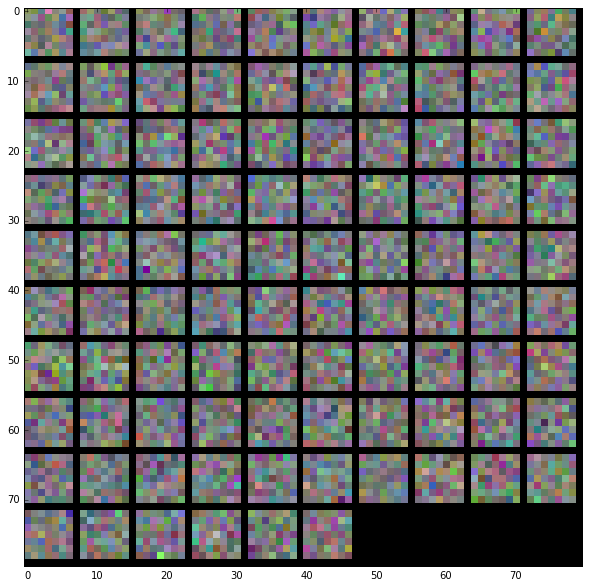

In [36]:
# the parameters are a list of [weights, biases]
filters = net.params['conv1'][0].data
vis_square(filters.transpose(0, 2, 3, 1))

The first layer output, `conv1` (rectified responses of the filters above, first 36 only)

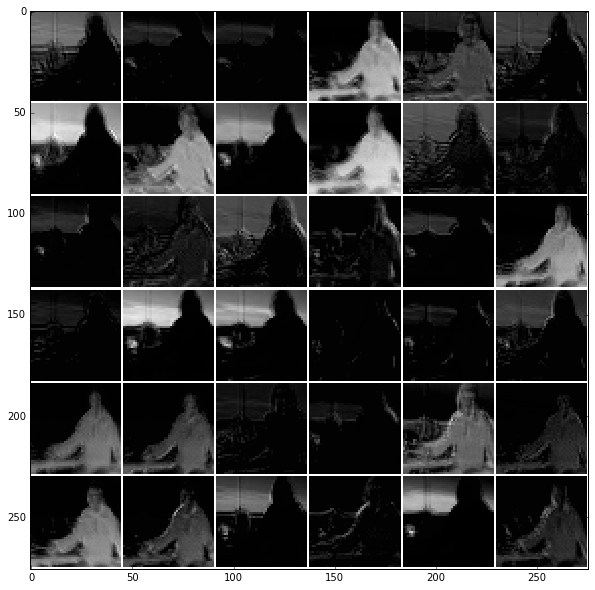

In [37]:
feat = net.blobs['conv1'].data[0, :36]
vis_square(feat, padval=1)

The second layer filters, `conv2`

There are 256 filters, each of which has dimension 5 x 5 x 48. We show only the first 48 filters, with each channel shown separately, so that each filter is a row.

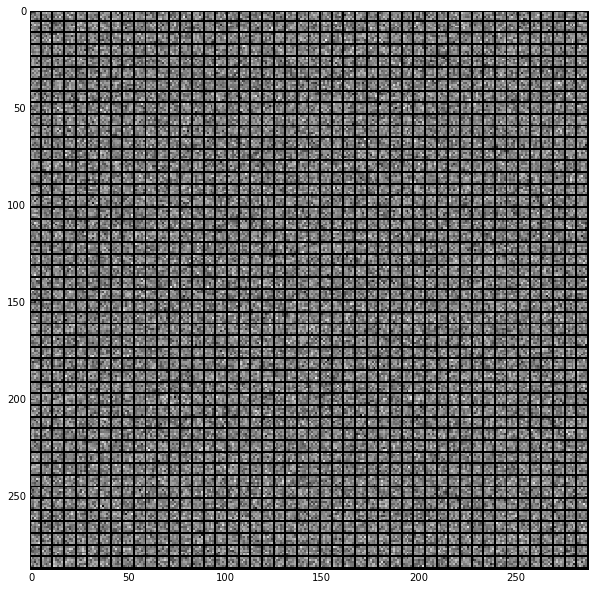

In [38]:
filters = net.params['conv2'][0].data
vis_square(filters[:48].reshape(48**2, 5, 5))

The second layer output, `conv2` (rectified, only the first 36 of 256 channels)

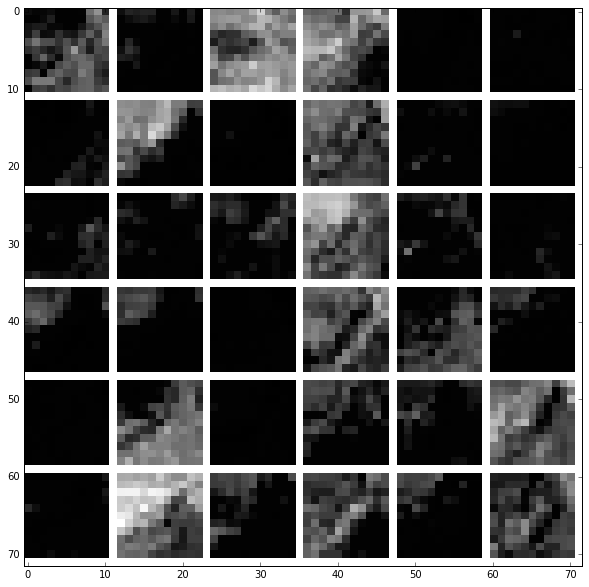

In [39]:
feat = net.blobs['conv2'].data[0, :36]
vis_square(feat, padval=1)

The third layer output, `conv3` (rectified, all 384 channels)

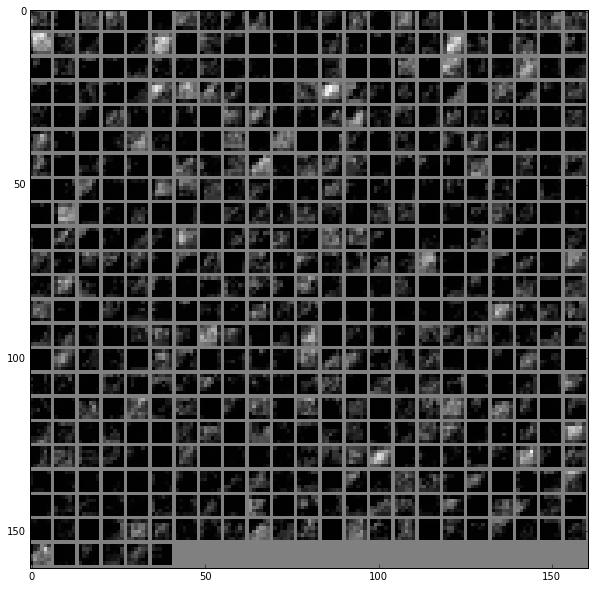

In [40]:
feat = net.blobs['conv3'].data[0]
vis_square(feat, padval=0.5)

The fourth layer output, `conv4` (rectified, all 384 channels)

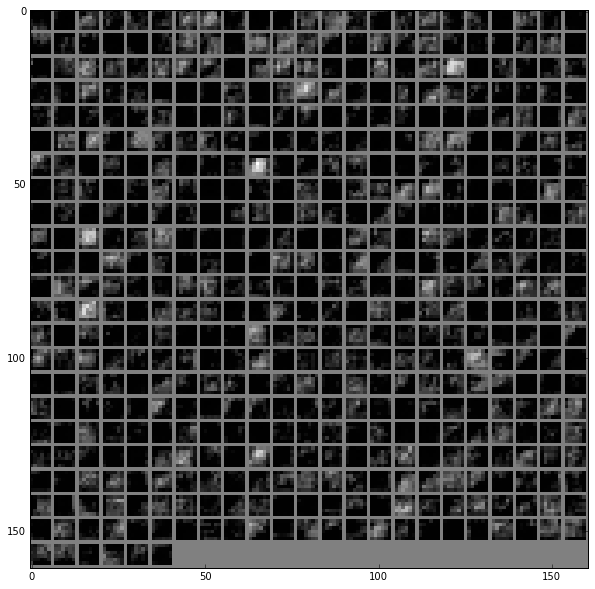

In [41]:
feat = net.blobs['conv4'].data[0]
vis_square(feat, padval=0.5)

The fifth layer output, `conv5` (rectified, all 256 channels)

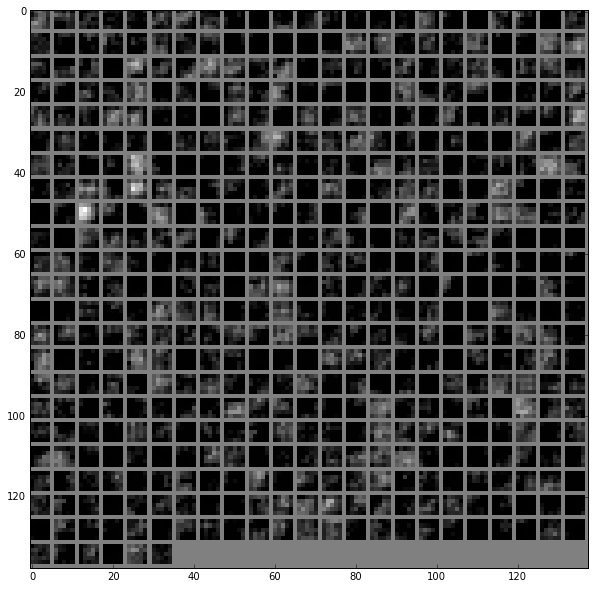

In [42]:
feat = net.blobs['conv5'].data[0]
vis_square(feat, padval=0.5)

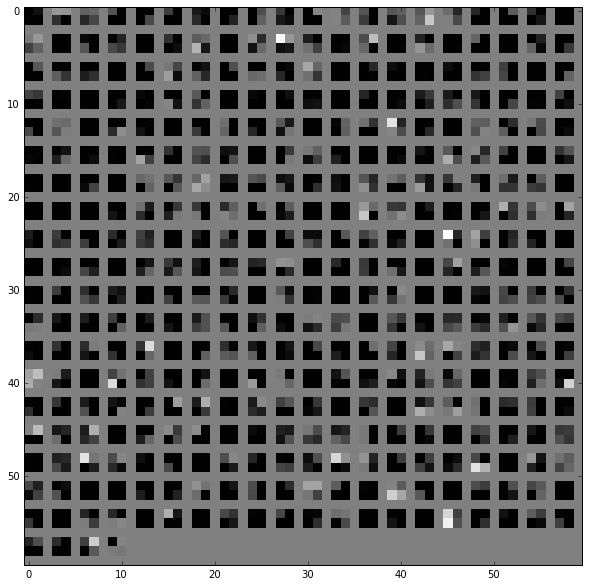

In [45]:
feat = net.blobs['conv6'].data[0]
vis_square(feat, padval=0.5)

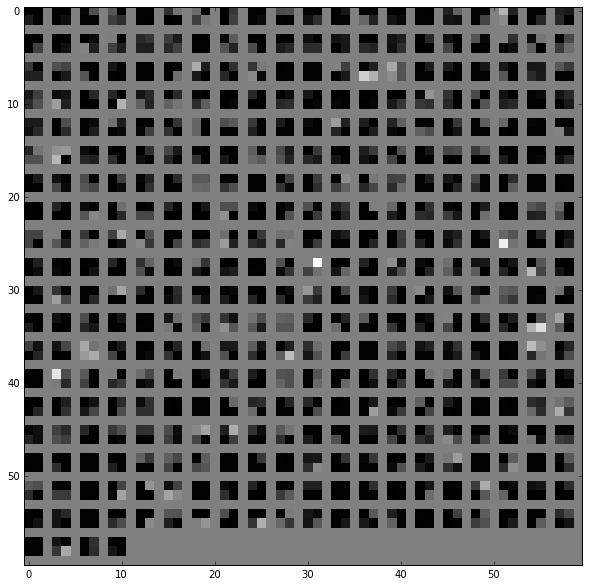

In [46]:
feat = net.blobs['conv7'].data[0]
vis_square(feat, padval=0.5)

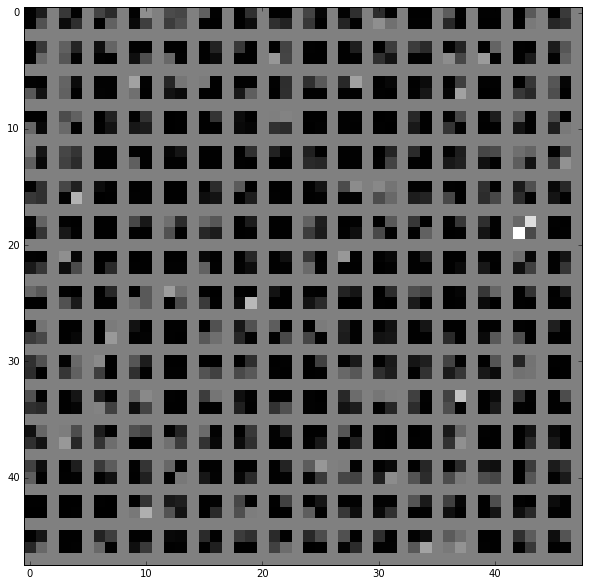

In [47]:
feat = net.blobs['conv8'].data[0]
vis_square(feat, padval=0.5)

The eighth layer after pooling, `pool8`

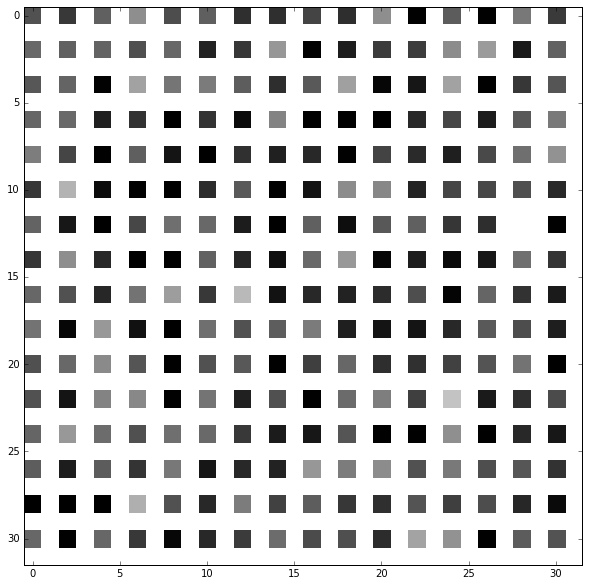

In [44]:
feat = net.blobs['pool8'].data[0]
vis_square(feat, padval=1)

The first fully connected layer, `fc9`

We show the output values and the histogram of the positive values

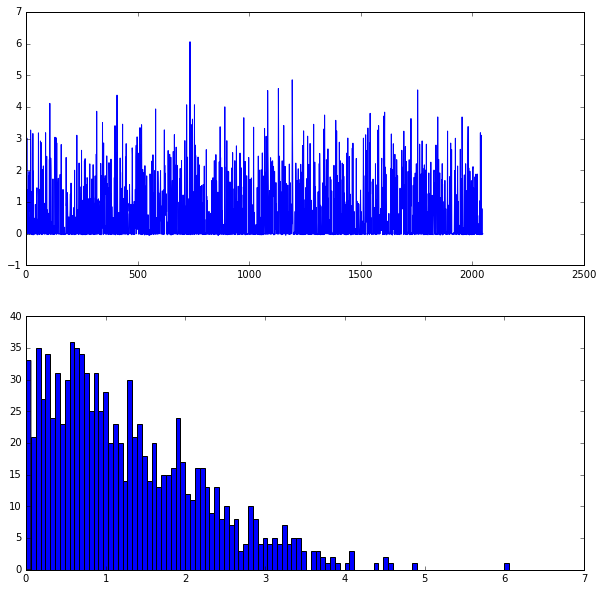

In [48]:
feat = net.blobs['fc9'].data[0]
plt.subplot(2, 1, 1)
plt.plot(feat.flat)
plt.subplot(2, 1, 2)
_ = plt.hist(feat.flat[feat.flat > 0], bins=100)

The second fully connected layer, `fc10` (rectified)

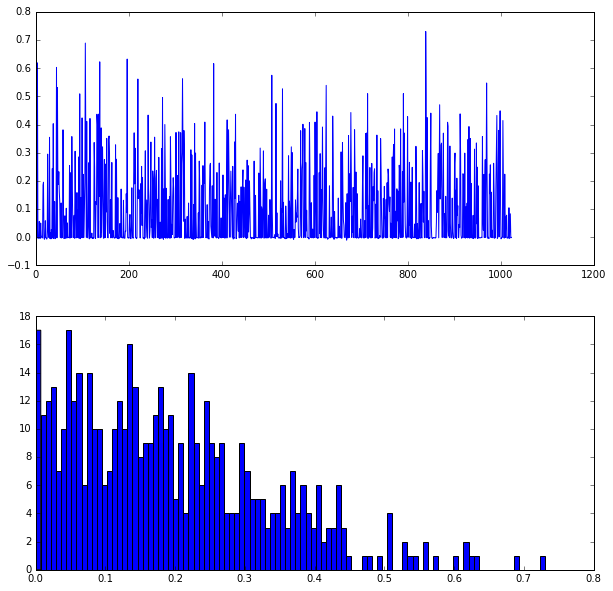

In [49]:
feat = net.blobs['fc10'].data[0]
plt.subplot(2, 1, 1)
plt.plot(feat.flat)
plt.subplot(2, 1, 2)
_ = plt.hist(feat.flat[feat.flat > 0], bins=100)

The final probability output, `prob`

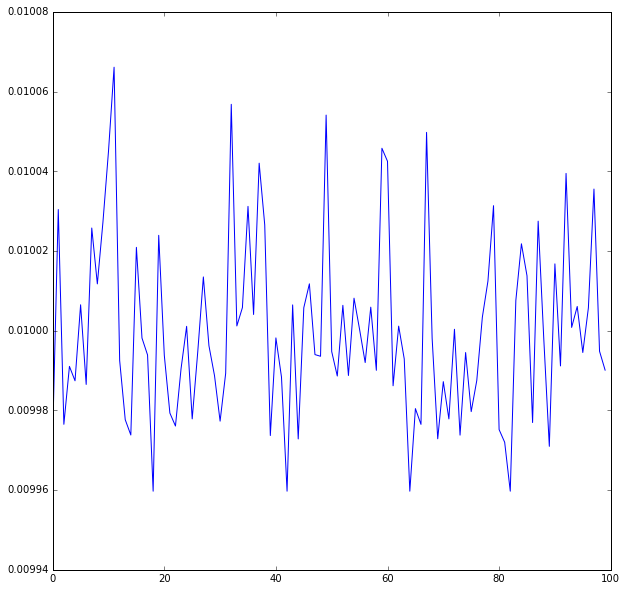

In [50]:
feat = net.blobs['probs'].data[0]
plt.plot(feat.flat)